[Ángulos originales]
UT: YZ=4.57°, XZ=-2.12°
XCT: YZ=0.29°, XZ=0.03°
initials [0.07469899539209626, -0.0375340339893099, 0.0]

[Buscando mejores ángulos de rotación...]

[Ángulos óptimos encontrados]
Rotación (X, Y, Z) en radianes: [ 9.46898397e-01 -7.21946825e-02  7.11851772e-04]
Rotación (X, Y, Z) en grados: [54.25328179816263, -4.136450611559765, 0.04078610216118021]
[Después de rotación óptima]
Ángulos: YZ=4.57°, XZ=-2.12°


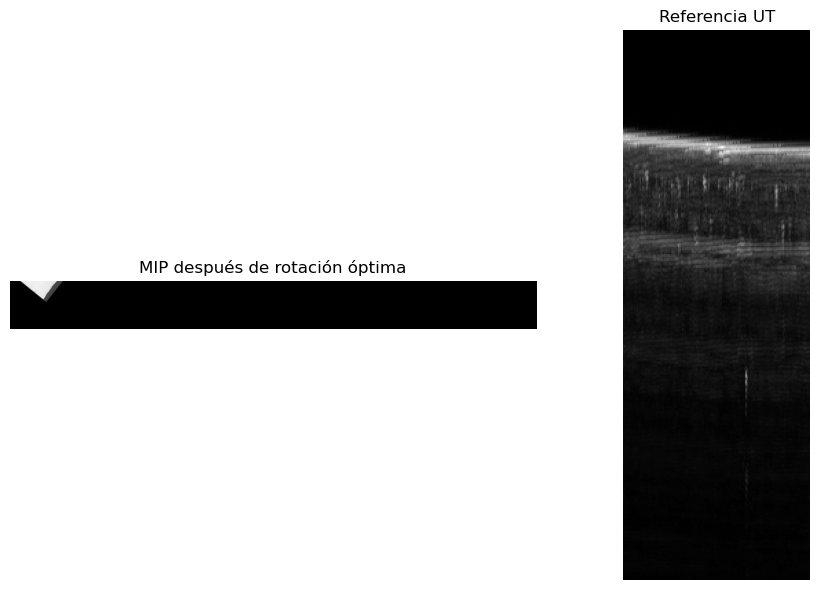

In [ ]:
import numpy as np
import cv2
from pathlib import Path
import tifffile as tiff
import utilities.rotate_volume 
from matplotlib import pyplot as plt
from utilities.angle import angles_estimation
from scipy.ndimage import rotate
import math
import SimpleITK as sitk
from scipy.optimize import minimize

# ---------- Funciones ----------

def convert_to_sitk(volume, pad=20):
    image_sitk = sitk.GetImageFromArray(volume)
    pad_lower = [pad, pad, pad]
    pad_upper = [pad, pad, pad]
    padded = sitk.ConstantPad(image_sitk, pad_lower, pad_upper, 0)
    return padded

def apply_rotation(image, center_index, rotation_angles_rad):
    center_physical = image.TransformIndexToPhysicalPoint(center_index)
    transform = sitk.Euler3DTransform()
    transform.SetCenter(center_physical)
    transform.SetRotation(*rotation_angles_rad)
    
    resampled = sitk.Resample(
        image,
        image,
        transform,
        sitk.sitkLinear,
        0.0,
        image.GetPixelID()
    )
    return resampled

def show_mips(volume_np, bscan_ref_np, title="MIP YZ"):
    mip_yz = np.max(volume_np, axis=2)
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(mip_yz, cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(np.max(bscan_ref_np, axis=2), cmap='gray')
    plt.title("Referencia UT")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def rotation_error(angles_rad, image_sitk, center_index, target_yz, target_xz):
    rotated = apply_rotation(image_sitk, center_index, angles_rad)
    rotated_np = sitk.GetArrayFromImage(rotated)

    result = angles_estimation(rotated_np)
    if result is None or result[0] is None or result[1] is None:
        return 1e6  # Penalización fuerte si no se puede calcular ángulo

    ang_yz, ang_xz = result
    error = (ang_yz - target_yz)**2 + (ang_xz - target_xz)**2
    return error

# ---------- Rutas ----------
pr_num = 12
file_XCT = Path(fr'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Airbus\Panel Pegaso\probetas\1\{pr_num}\frontal_90right.tif')
file_UT = Path(fr'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Panel PEGASO\probetas\1\{pr_num}\{pr_num}_lente_amplitude.tif')

volume_XCT = tiff.imread(file_XCT)
volume_UT = tiff.imread(file_UT)

# ---------- Ángulos ----------
angle_yz_ut, angle_xz_ut = angles_estimation(volume_UT)

angle_yz_xct, angle_xz_xct = angles_estimation(volume_XCT)


print('[Ángulos originales]')
print(f'UT: YZ={angle_yz_ut:.2f}°, XZ={angle_xz_ut:.2f}°')
print(f'XCT: YZ={angle_yz_xct:.2f}°, XZ={angle_xz_xct:.2f}°')

# ---------- Convertir a radianes ----------
rad_yz_ut = math.radians(angle_yz_ut)
rad_xz_ut = math.radians(angle_xz_ut)
rad_yz_xct = math.radians(angle_yz_xct)
rad_xz_xct = math.radians(angle_xz_xct)

# ---------- Volumen XCT como SimpleITK con padding ----------
image_sitk = convert_to_sitk(volume_XCT, pad=20)
center_index = (1, 1, 1)  # Se puede mejorar dinámicamente

# ---------- Optimización de ángulos ----------
target_yz = angle_yz_ut
target_xz = angle_xz_ut
initial_guess = [rad_yz_ut - rad_yz_xct, rad_xz_ut - rad_xz_xct, 0.0]

print('initials', initial_guess)

print('\n[Buscando mejores ángulos de rotación...]')

result = minimize(rotation_error, initial_guess,args=(image_sitk, center_index, target_yz, target_xz),method='Powell')

best_angles = result.x
print(f'\n[Ángulos óptimos encontrados]')
print(f'Rotación (X, Y, Z) en radianes: {best_angles}')
print(f'Rotación (X, Y, Z) en grados: {[math.degrees(a) for a in best_angles]}')

# ---------- Aplicar rotación óptima ----------
image_rotated_opt = apply_rotation(image_sitk, center_index, best_angles)
array_rotated_opt = sitk.GetArrayFromImage(image_rotated_opt)

# ---------- Ángulos después de rotación ----------
final_angle_yz, final_angle_xz = angles_estimation(array_rotated_opt)
print('[Después de rotación óptima]')
print(f'Ángulos: YZ={final_angle_yz:.2f}°, XZ={final_angle_xz:.2f}°')

# ---------- Visualización ----------
show_mips(array_rotated_opt, volume_UT, title="MIP después de rotación óptima")


In [ ]:

# ---------- Funciones ----------

def convert_to_sitk(volume, pad=20):
    image_sitk = sitk.GetImageFromArray(volume)
    pad_lower = [pad, pad, pad]
    pad_upper = [pad, pad, pad]
    padded = sitk.ConstantPad(image_sitk, pad_lower, pad_upper, 0)
    return padded

def apply_rotation(image, center_index, rotation_angles_rad):
    center_physical = image.TransformIndexToPhysicalPoint(center_index)
    transform = sitk.Euler3DTransform()
    transform.SetCenter(center_physical)
    transform.SetRotation(*rotation_angles_rad)
    
    resampled = sitk.Resample(
        image,
        image,
        transform,
        sitk.sitkLinear,
        0.0,
        image.GetPixelID()
    )
    return resampled

def show_mips(volume_np, bscan_ref_np, title="MIP YZ"):
    mip_yz = np.max(volume_np, axis=2)
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(mip_yz, cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(np.max(bscan_ref_np, axis=2), cmap='gray')
    plt.title("Referencia UT")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def rotation_error(angles_rad, image_sitk, center_index, target_yz, target_xz):
    rotated = apply_rotation(image_sitk, center_index, angles_rad)
    rotated_np = sitk.GetArrayFromImage(rotated)

    result = angles_estimation(rotated_np)
    if result is None or result[0] is None or result[1] is None:
        return 1e6  # Penalización fuerte si no se puede calcular ángulo

    ang_yz, ang_xz = result
    error = (ang_yz - target_yz)**2 + (ang_xz - target_xz)**2
    return error

# ---------- Rutas ----------
pr_num = 12
file_XCT = Path(fr'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Airbus\Panel Pegaso\probetas\1\{pr_num}\frontal_90right.tif')
file_UT = Path(fr'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Panel PEGASO\probetas\1\{pr_num}\{pr_num}_lente_amplitude.tif')

volume_XCT = tiff.imread(file_XCT)
volume_UT = tiff.imread(file_UT)

# ---------- Ángulos ----------
angle_yz_ut, angle_xz_ut = angles_estimation(volume_UT)

angle_yz_xct, angle_xz_xct = angles_estimation(volume_XCT)


print('[Ángulos originales]')
print(f'UT: YZ={angle_yz_ut:.2f}°, XZ={angle_xz_ut:.2f}°')
print(f'XCT: YZ={angle_yz_xct:.2f}°, XZ={angle_xz_xct:.2f}°')

# ---------- Convertir a radianes ----------
rad_yz_ut = math.radians(angle_yz_ut)
rad_xz_ut = math.radians(angle_xz_ut)
rad_yz_xct = math.radians(angle_yz_xct)
rad_xz_xct = math.radians(angle_xz_xct)

# ---------- Volumen XCT como SimpleITK con padding ----------
image_sitk = convert_to_sitk(volume_XCT, pad=20)
center_index = (1, 1, 1)  # Se puede mejorar dinámicamente

# ---------- Optimización de ángulos ----------
target_yz = angle_yz_ut
target_xz = angle_xz_ut
initial_guess = [rad_yz_ut - rad_yz_xct, rad_xz_ut - rad_xz_xct, 0.0]

print('initials', initial_guess)

print('\n[Buscando mejores ángulos de rotación...]')

result = minimize(rotation_error, initial_guess,args=(image_sitk, center_index, target_yz, target_xz),method='Powell')

best_angles = result.x
print(f'\n[Ángulos óptimos encontrados]')
print(f'Rotación (X, Y, Z) en radianes: {best_angles}')
print(f'Rotación (X, Y, Z) en grados: {[math.degrees(a) for a in best_angles]}')

# ---------- Aplicar rotación óptima ----------
image_rotated_opt = apply_rotation(image_sitk, center_index, best_angles)
array_rotated_opt = sitk.GetArrayFromImage(image_rotated_opt)

# ---------- Ángulos después de rotación ----------
final_angle_yz, final_angle_xz = angles_estimation(array_rotated_opt)
print('[Después de rotación óptima]')
print(f'Ángulos: YZ={final_angle_yz:.2f}°, XZ={final_angle_xz:.2f}°')

# ---------- Visualización ----------
show_mips(array_rotated_opt, volume_UT, title="MIP después de rotación óptima")
